## Install all dependencies</ul>

In [ ]:
# Math/Plotting
!pip install numpy
!pip install matplotlib
!pip install scikit-learn

# Machine Learning
!pip install tensorflow
!pip install keras
!pip install deepxde

## Import all packages

In [33]:
#!/usr/bin/env python
# coding: utf-8
import sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import deepxde as dde
# from deepxde.backend import tf
import tensorflow as tf

# Import data
Nx and Ny are the sizes of the data array being imported for each sample(e.g. 128 and 128 --> 16384. As can be seen by the print statement for the array sizes this produces a 5000 x 16384 array.

$U_0$ is array of all the U($x_n$) values which is concatenated with the various xy sensor values and is fed into the branch network. S is the array of all the Y values which is also concatenated with the various xy sensor values and is fed into the trunk network. Both of these datasets have a 5000 data sample training set and a 500 sample testing set.

In [34]:
# In[3]:

Nx = 128
Ny = 128
m = Nx * Ny
###  N number of samples 1000
###  m number of points 40
###  P number of output sensors (coordinates) 1600
### x_train is a tuple of u0(N,m) and output sensores, all coordinates xy_train_testing(P,2)
### y_train is target solutions (our s) u(N,P)

seed = 123 
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(seed)

dde.config.set_default_float("float64")

u0_train = np.load('data_u0_train_ht_3.npy').astype(np.float64)

u0_testing = np.load('../NOISE_DATA_3/data_u0_testing_ht_3.npy').astype(np.float64)

#s_train = np.load('s_train_10K.npy').astype(np.float32)
s_train = np.load('data_s_train_ht_3.npy').astype(np.float64)

s_testing = np.load('../NOISE_DATA_3/data_s_testing_ht_3.npy').astype(np.float64)
xy_train_testing = np.load('xy_train_test_ht.npy').astype(np.float64)

print('u0_train.shape = ', u0_train.shape)
print('type of u0_train = ', type(u0_train))
print('u0_testing.shape = ',u0_testing.shape)
print('s_train.shape = ',s_train.shape)
print('s_testing.shape = ',s_testing.shape)
print('xy_train_testing.shape', xy_train_testing.shape)

x_train = (u0_train, xy_train_testing)
y_train = s_train 
x_test = (u0_testing, xy_train_testing)
y_test = s_testing



#x_train, y_train = get_data("train_IC2.npz")
#x_test, y_test = get_data("test_IC2.npz")

Set the default float type to float64
u0_train.shape =  (5000, 16384)
type of u0_train =  <class 'numpy.ndarray'>
u0_testing.shape =  (500, 16384)
s_train.shape =  (5000, 16384)
s_testing.shape =  (500, 16384)
xy_train_testing.shape (16384, 2)


## Creating the Network
From the deepxde package the dataset is constrcuted using the triple cartesian product dataset format. The corresponding triple cartesin product network is then chosen with an input array determining its network size (e.g. a fully connected layer of 16384 connected to a layer of 100 repeated 6 times in the code below for the branch network).


In [35]:
data = dde.data.TripleCartesianProd(x_train, y_train, x_test, y_test)
#print('x_train.shape = ', np.array(x_train).shape)
#print("type of x_train", type(x_train))
#print('x_train = ', x_train)
#print('y_train.shape = ', y_train.shape)
#print('x_test.shape = ', x_test.shape)
#print('y_test.shape = ', y_test.shape)
#print("type of data", type(data))

net = dde.maps.DeepONetCartesianProd(
    [m, 100, 100, 100, 100, 100, 100], [2, 100, 100, 100, 100, 100, 100], "relu", "Glorot normal"
)

#net = dde.maps.DeepONetCartesianProd(
#    [m, 100, 100, 100, 100, 100, 100], [2, 100, 100, 100, 100, 100, 100], "relu", "glorot_normal"
#)



model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    decay=("inverse time", 1, 1e-4),
    metrics=["mean l2 relative error"],
)
# IC1
# losshistory, train_state = model.train(epochs=100000, batch_size=None)
# IC2
losshistory, train_state = model.train(epochs=1000, batch_size=64)

y_pred = model.predict(data.test_x)
print('y_pred.shape =', y_pred.shape)
##np.savetxt("y_pred_deeponet.dat", y_pred[0].reshape(nt, nx))
##np.savetxt("y_true_deeponet.dat", data.test_y[0].reshape(nt, nx))
##np.savetxt("y_error_deeponet.dat", (y_pred[0] - data.test_y[0]).reshape(nt, nx))
error_s = []
for i in range(50):
    error_s_tmp = np.linalg.norm(y_test[i] - y_pred[i]) / np.linalg.norm(y_test[i])
    error_s.append(error_s_tmp)
error_s = np.stack(error_s)
print("error_s = ", error_s)

Compiling model...
'compile' took 0.001492 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [1.74e+00]    [1.77e+00]    [1.00e+00]    
1000      [2.81e-02]    [3.46e-02]    [1.58e-01]    

Best model at step 1000:
  train loss: 2.81e-02
  test loss: 3.46e-02
  test metric: [1.58e-01]

'train' took 51.969799 s

y_pred.shape = (500, 16384)
error_s =  [0.21663021 0.12779397 0.21667767 0.1615303  0.24551495 0.18449205
 0.15422969 0.09947338 0.18423703 0.1713989  0.24764684 0.1279597
 0.1598671  0.16823726 0.18963015 0.22821633 0.11708461 0.2228927
 0.13916416 0.16534471 0.11819026 0.13926738 0.20632452 0.14934124
 0.09211648 0.15426105 0.08909995 0.18034274 0.09183532 0.27823105
 0.16506368 0.14505515 0.24338612 0.09535048 0.09150578 0.16193551
 0.12108068 0.08999141 0.16448756 0.21012581 0.2534046  0.17067147
 0.12537426 0.1394785  0.12353159 0.05122109 0.17900909 0.12743914
 0.21927956 0.09064649]


## Plotting Results

Uses matplotlib to plot the figures of the original datapoints that made up the training and testing sets, the true distribution that the data was selected from, and the distribution of the network's prediction.

41


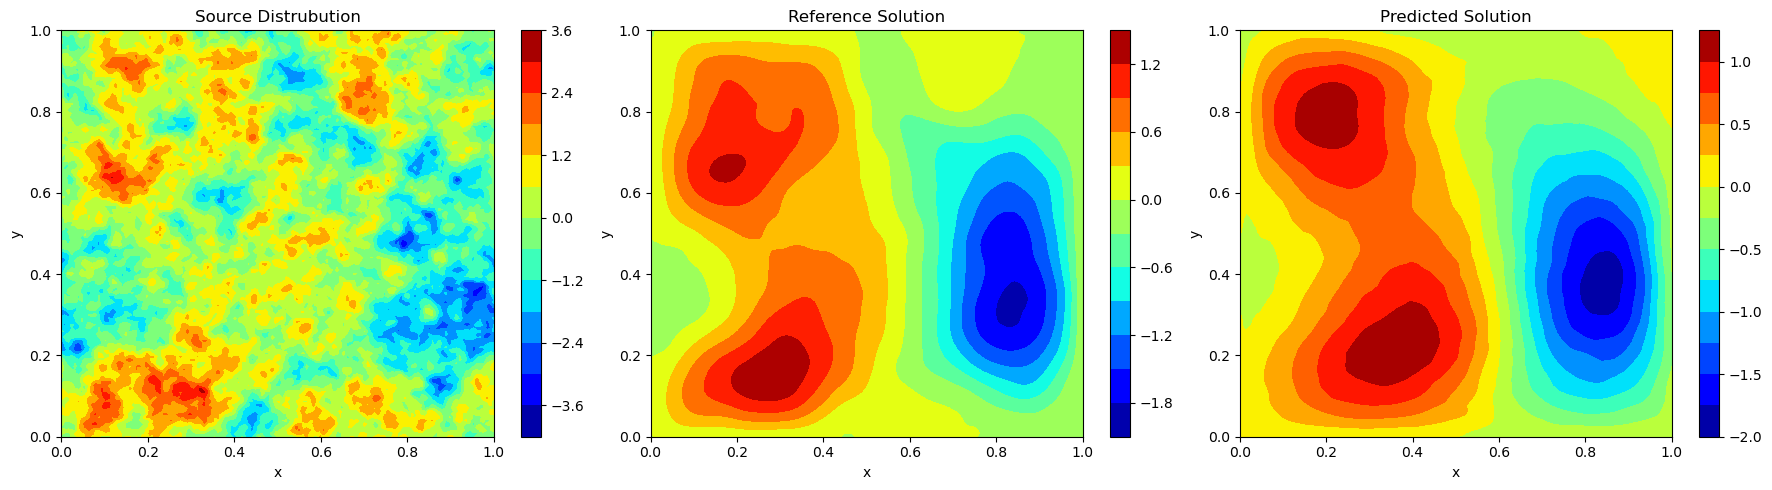

In [36]:
import matplotlib.pyplot as plt
import pylab as py
# Defining custom plotting functions
def my_contourf(x,y,F,ttl):
    cnt = py.contourf(x,y,F,12,cmap = 'jet')
    py.colorbar()
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0

rand_num = np.random.randint(Nx)
print(rand_num)
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)

u0_testing_nx_ny = u0_testing[4].reshape(Nx,Ny)
s_testing_nx_ny = y_test[4].reshape(Nx,Ny)
s_pred_nx_ny = y_pred[4].reshape(Nx,Ny)


fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
#py.figure(figsize = (14,7))
my_contourf(x,y,u0_testing_nx_ny.T,r'Source Distrubution')
plt.tight_layout()
plt.subplot(1,3,2)
#py.figure(figsize = (14,7))
my_contourf(x,y,s_testing_nx_ny,r'Reference Solution')
plt.tight_layout()
plt.subplot(1,3,3)
#py.figure(figsize = (14,7))
my_contourf(x,y,s_pred_nx_ny,r'Predicted Solution')
plt.tight_layout()
#plt.savefig("temperature_sample{}_jet12.jpg".format(i+1), dpi=300)
plt.savefig("temperature_sample4_5000_train3_test5.jpg", dpi=300)
plt.show()